## Global Settings and Imports

In [1]:
# jupyter notebook에서 import 해서 쓰는 모듈의 코드가 변경될 시, 변동 사항을 자동으로 반영해주는 기능 켜기
%load_ext autoreload
%autoreload 2

In [2]:
import argparse
import yaml
from dotmap import DotMap
from os import path
import numpy as np
import torch
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning import Trainer
from models.lstur import LSTUR
from models.nrms import NRMS
from models.naml import NAML
from models.naml_simple import NAML_Simple
from models.sentirec import SENTIREC
from models.robust_sentirec import ROBUST_SENTIREC
from data.dataset import BaseDataset
from tqdm import tqdm

## Prepare parameters

In [7]:
args = argparse.Namespace(
    config = "config/model/nrms/exp_manual1.yaml",
    ckpt = "logs/lightning_logs/checkpoints/nrms/exp1/epoch=11-val_auc_epoch=0.9333.ckpt"
)

with open(args.config, 'r') as ymlfile:
    config = yaml.load(ymlfile, Loader=yaml.FullLoader)
    config = DotMap(config)

assert(config.name in ["lstur", "nrms", "naml", "naml_simple", "sentirec", "robust_sentirec"])

pl.seed_everything(1234)

logger = TensorBoardLogger(
    **config.logger
)

Seed set to 1234


## Load data

In [4]:
preprocess_path = f"{config.preprocess_data_path}/{config.dataset_size}/"

test_dataset = BaseDataset(
    path.join(preprocess_path + config.test_behavior),
    path.join(preprocess_path + config.test_news), 
    config)
test_loader = DataLoader(
    test_dataset,
    **config.test_dataloader)

100%|██████████| 2/2 [00:00<00:00, 1166.22it/s]


In [5]:
# load embedding pre-trained embedding weights
embedding_weights=[]
with open(path.join(preprocess_path + config.embedding_weights), 'r') as file: 
    lines = file.readlines()
    for line in tqdm(lines):
        weights = [float(w) for w in line.split(" ")]
        embedding_weights.append(weights)
pretrained_word_embedding = torch.from_numpy(
    np.array(embedding_weights, dtype=np.float32)
)

100%|██████████| 3685/3685 [00:00<00:00, 19879.70it/s]


## Load model from checkpoint

In [8]:
print(config.name)
if config.name == "lstur":
    model = LSTUR.load_from_checkpoint(
        args.ckpt, 
        config=config, 
        pretrained_word_embedding=pretrained_word_embedding
    )
elif config.name == "nrms":
    model = NRMS.load_from_checkpoint(
        args.ckpt, 
        config=config, 
        pretrained_word_embedding=pretrained_word_embedding
    )
elif config.name == "naml":
    model = NAML.load_from_checkpoint(
        args.ckpt, 
        config=config, 
        pretrained_word_embedding=pretrained_word_embedding
    )
elif config.name == "naml_simple":
    model = NAML_Simple.load_from_checkpoint(
        args.ckpt, 
        config=config, 
        pretrained_word_embedding=pretrained_word_embedding
    )
elif config.name == "sentirec":
    model = SENTIREC.load_from_checkpoint(
        args.ckpt, 
        config=config, 
        pretrained_word_embedding=pretrained_word_embedding
    )
elif config.name == "robust_sentirec":
    model = ROBUST_SENTIREC.load_from_checkpoint(
        args.ckpt, 
        config=config, 
        pretrained_word_embedding=pretrained_word_embedding
    )
# elif:
    # UPCOMING MODELS

nrms


## Test model

In [9]:
trainer = Trainer(
    **config.trainer,
    logger=logger
)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\USER\anaconda3\envs\newsrec\lib\site-packages\pytorch_lightning\trainer\setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


In [11]:
test_result = trainer.test(
    model=model, 
    dataloaders=test_loader
)

c:\Users\USER\anaconda3\envs\newsrec\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         Test metric                 DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_auc_epoch             0.4750000238418579
test_ils_senti@10_bert_epoch       0.465101420879364
test_ils_senti@10_vader_epoch     0.19995611906051636
 test_ils_senti@5_bert_epoch      0.49809348583221436
test_ils_senti@5_vader_epoch      0.15544500946998596
   test_ils_topic@10_epoch        0.0555555485188961
   test_ils_topic@5_epoch         0.07500000298023224
       test_mrr_epoch              0.148326575756073
     test_ndcg@10_epoch           0.21533828973770142
      test_ndcg@5_epoch           0.21533828973770142
  test_senti@10_bert_epoch        0.45023995637893677
  test_senti@10_vader_epoch               0.0
   test_senti@5_bert_epoch        0.22032491862773895
  test_senti@5_vad

## 기타 실험용 코드

In [ ]:
test_dataset[0]

In [ ]:
test_dataset[0]['c_title']

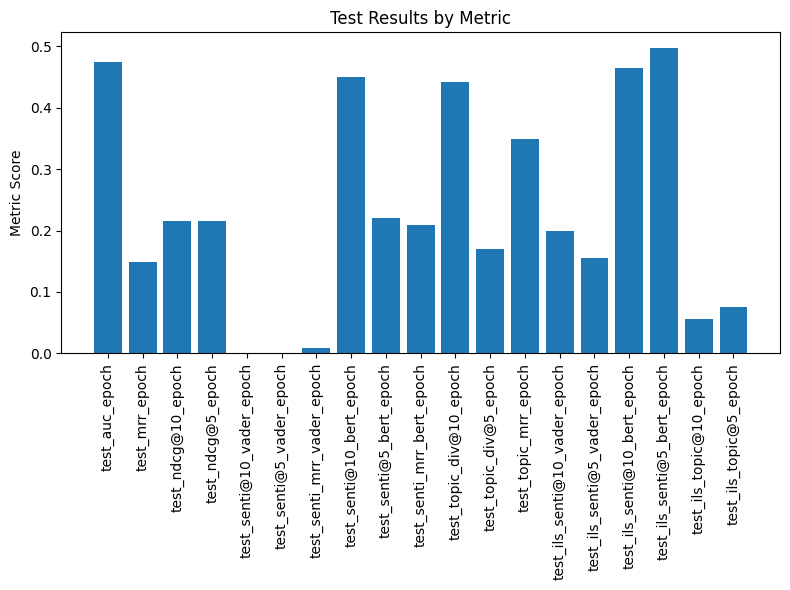

In [ ]:
# 간단한 시각화
import matplotlib.pyplot as plt

metrics = test_result[0]
keys = metrics.keys()
values = metrics.values()

# 그림 크기 설정
plt.figure(figsize=(8, 6))

# 막대 그래프
plt.bar(keys, values)

# 레이블 회전 + 정렬
plt.xticks(rotation=90)
plt.ylabel("Metric Score")
plt.title("Test Results by Metric")

# 레이아웃 깔끔하게
plt.tight_layout()

# 출력
plt.show()